In [39]:
import numpy as np
import pandas as pd
data_raw = pd.read_excel("../data.xlsx")
weights = data_raw[["Weight"]]
scenarios = data_raw.drop(columns = ["Weight", "Unnamed: 36"]).iloc[:,0:13]

In [40]:
def mean_and_var(scenarios = scenarios, weights = weights):
    m,n = scenarios.shape
    weights_reshaped = np.asarray(weights).reshape(m,)
    mu = np.average(scenarios, axis=0, weights = weights_reshaped)
    covar = np.cov(scenarios, rowvar = False, aweights = weights_reshaped) #* 252 #annualization constant
    return mu, covar
mu, covar = mean_and_var()

In [66]:
def markoviz_optimizer(scenarios, weights, mu_0, disp = True):
    from scipy.optimize import minimize, LinearConstraint, Bounds
    mu, covar = mean_and_var(scenarios, weights)
  
    m, n = covar.shape
    x0 = np.ones(m)/m
    
    def jac(x):
        return 2 * covar @ x
    
    def objective_function(x):
        return  x.T @ covar @ x
    
    bounds = Bounds(lb = np.zeros(m), ub = np.ones(m)) #[(0, 1) for i in range(m)]
    constraints = (LinearConstraint(np.ones(m), lb=1, ub=1), #Sum of weights 1
                  LinearConstraint(mu, lb=mu_0, ub=np.inf) #Greater or equal to a certain return level
                  ) 
    
    res = minimize(objective_function,
                   jac=jac,
                   x0 = x0,
                   bounds = bounds,
                   constraints = constraints,
                   tol=0.00001,
                   options = {"disp": disp})
    return res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 20.135339884167145
            Iterations: 3
            Function evaluations: 4
            Gradient evaluations: 3
Var: 20.135339884167145
Mu: 0.7500000000088178
Sum of x: 1.0
Flag: True 
Message: Optimization terminated successfully
x_0 : 0.0
x_1 : 0.0
x_2 : 0.69
x_3 : 0.0
x_4 : 0.18
x_5 : 0.0
x_6 : 0.0
x_7 : 0.0
x_8 : 0.0
x_9 : 0.0
x_10 : 0.13
x_11 : 0.0
x_12 : 0.0


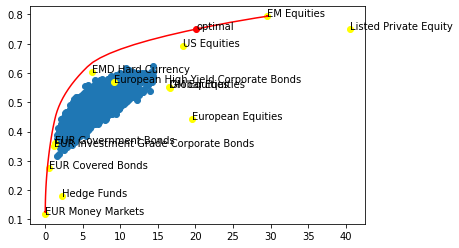

In [71]:
res = markoviz_optimizer(scenarios, weights, mu_0 = 0.75)
x = res.x
np.round(x, decimals = 2)
print("Var:", x.T @ covar @ x)
print("Mu:",  mu.dot(x) )
print("Sum of x:", np.round(np.sum(x),decimals = 2))
print("Flag:", res.success, "\nMessage:", res.message )
for i,val in enumerate(x):
  print("x_"+str(i),":", np.round(val, decimals = 2))

m,n = covar.shape
port_returns = []
port_vol = []
#port_weights = [] 
for i in range(0, 50000):
  y = np.random.rand(m,1)
  y = y/np.sum(y)
  #port_weights.append(x)
  port_returns.append(mu @ y)
  port_vol.append(y.T @ covar @ y)

frontier_mu = np.array([])
frontier_var = np.array([])
for j in np.linspace(0.0, 1.5, 100):
  opt = markoviz_optimizer(scenarios, weights, mu_0 = j, disp = False)
  frontier_mu = np.append(frontier_mu, mu @ opt.x)
  frontier_var = np.append( frontier_var, opt.x.T @ covar @ opt.x)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#plt.xlim((-5,30))
#plt.ylim(-0.5,1)
ax.scatter(port_vol, port_returns)
ax.scatter(np.diag(covar), mu, color = "yellow");
for i, txt in enumerate(scenarios.columns):
    ax.annotate(txt, (np.diag(covar)[i], mu[i]))
ax.scatter(x.T @ covar @ x,mu @ x, color='red');
ax.annotate("optimal", (x.T @ covar @ x,mu @ x));
ax.plot(frontier_var, frontier_mu, color='red');